# Investigate Betting Strategies Based On Simple Rules For Estimating Fighter's Prob of Winning 


In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
pd.set_option('display.max_columns', 500)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy.random

In [152]:
bets = pd.read_csv('../../../data/datasets_for_analysis/final_datasets/odds_w_outcomes.csv')
bets['Card_Date'] = pd.to_datetime(bets['Card_Date'] )
bets['year'] = bets['Card_Date'].dt.year

In [153]:
print(str(bets.shape[0]/2)+ " "+
      'fights in the dataset from '+str(bets.year.min())+' to '+
     str(bets.year.max()))

print(bets.Outcome.value_counts())
bets = bets[bets.Outcome == 'def']

print(str(bets.shape[0]/2)+ " "+
      'fights in the dataset that did not result in a NC or draw from '+str(bets.year.min())+' to '+
     str(bets.year.max()))

4702.0 fights in the dataset from 2008 to 2020
def    9240
vs      164
Name: Outcome, dtype: int64
4620.0 fights in the dataset that did not result in a NC or draw from 2008 to 2020


In [154]:
# convert decimal odds to probabilities using the balanced book method
betting_sites= ['5Dimes','BetDSI','BookMaker','SportBet','Bet365','Bovada', 
                'Sportsbook','William_H','Pinnacle','SportsInt','BetOnline','Intertops']

for col in betting_sites:
    bets[col+"_prob"] =  ((bets[col]**-1) - bets[col+"_vig"])/(1-bets[col+"_vig"]) 

bets["avg_prob"] = bets[[col+"_prob" for col in betting_sites]].apply("mean", axis = 1)

,avg_prob,bet_won,diff,n
avg_prob,,,,
"(0.05, 0.1]",0.082853,0.047619,-0.035234,42
"(0.1, 0.15000000000000002]",0.130845,0.107143,-0.023703,140
"(0.15000000000000002, 0.2]",0.177782,0.166667,-0.011115,336
"(0.2, 0.25]",0.226675,0.213018,-0.013657,507
"(0.25, 0.30000000000000004]",0.276361,0.261654,-0.014707,665
"(0.30000000000000004, 0.35000000000000003]",0.326098,0.332882,0.006784,739
"(0.35000000000000003, 0.4]",0.376106,0.419608,0.043502,765
"(0.4, 0.45]",0.422837,0.457560,0.034722,754
"(0.45, 0.5]",0.475653,0.463596,-0.012057,673


                            WLS Regression Results                            
Dep. Variable:                bet_won   R-squared:                       0.983
Model:                            WLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     949.3
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           1.13e-15
Time:                        10:43:52   Log-Likelihood:                 38.261
No. Observations:                  18   AIC:                            -72.52
Df Residuals:                      16   BIC:                            -70.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0009      0.017     -0.052      0.9

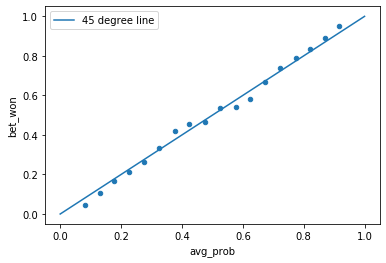

In [155]:
# how well does the average probability track actual outcomes

bins = np.arange(0,1, .05)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets.avg_prob, divided)
grouped = bets.groupby(consensus_group)['bet_won', 'avg_prob'].agg(avg_prob = ('avg_prob', 'mean'),
                                                                   bet_won=('bet_won', 'mean'),
                                                                      n = ('bet_won', 'size'))
grouped = grouped[grouped.bet_won.notna()]
grouped['diff'] = grouped['bet_won'] - grouped['avg_prob']
display(grouped[['avg_prob','bet_won','diff', 'n']])

fig, ax = plt.subplots()
grouped.plot.scatter(x='avg_prob', y = 'bet_won', ax = ax)
x = np.linspace(0, 1, 100)
ax.plot(x, x, label = '45 degree line')
ax.legend(loc='best')
model = smf.wls(formula='bet_won ~ avg_prob', data=grouped, weights = grouped.n).fit()
print(model.summary())

It looks like the average probability has closely predicted the true probability with possibly a little opportunity in the 35 - 45 % probability range where underdogs seem to be winning ~4% more often than the average probabilities suggest. This seems worth investigating further. What's likely happening here is a lot of money is flowing to one side of what should be a 50 - 50 matchup, thereby making one side a better bet

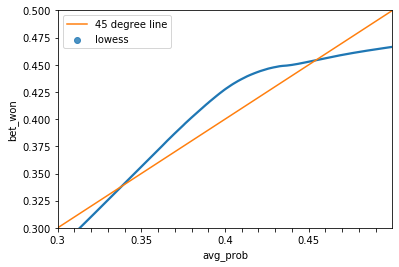

In [156]:
fig, ax = plt.subplots()

sns.regplot(x = 'avg_prob', y = 'bet_won', data = bets[(bets.avg_prob >= .3) & (bets.avg_prob <= .5)],
           lowess = True, ax = ax, label = 'lowess')
ax.plot([.3, .5], [.3, .5], label = "45 degree line")
ax.set_ylim(.3, .5)
ax.set_xlim(.3, .5)
ax.set_xticks(np.arange(.3,.5, .01 ))
ax.set_xticklabels([np.round(x,2) if i% 5 == 0 else '' for i, x in enumerate(np.arange(.3,.5, .01))])
ax.legend(loc='best')

Looks like bets in the 37% - 43% range did quite well

,avg_prob,bet_won,diff,n
avg_prob,,,,
"(0.05, 0.1]",0.082984,0.050000,-0.032984,40
"(0.1, 0.15000000000000002]",0.130285,0.115044,-0.015241,113
"(0.15000000000000002, 0.2]",0.176919,0.157025,-0.019894,242
"(0.2, 0.25]",0.227397,0.211940,-0.015457,335
"(0.25, 0.30000000000000004]",0.276686,0.247748,-0.028938,444
"(0.30000000000000004, 0.35000000000000003]",0.325810,0.331301,0.005490,492
"(0.35000000000000003, 0.4]",0.376810,0.436945,0.060135,563
"(0.4, 0.45]",0.423088,0.463497,0.040409,589
"(0.45, 0.5]",0.475704,0.465887,-0.009817,513


                            WLS Regression Results                            
Dep. Variable:                bet_won   R-squared:                       0.971
Model:                            WLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     536.7
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           9.81e-14
Time:                        10:43:56   Log-Likelihood:                 33.482
No. Observations:                  18   AIC:                            -62.96
Df Residuals:                      16   BIC:                            -61.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0028      0.023     -0.119      0.9

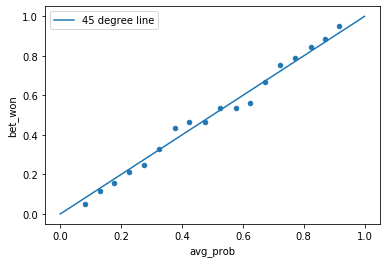

In [157]:
# repeat analysis but look at more recent years and older years separately
# recent years 2013 - 2020
bets_recent = bets[bets.year >= 2013]
bins = np.arange(0,1, .05)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets_recent.avg_prob, divided)
grouped = bets_recent.groupby(consensus_group)['bet_won', 'avg_prob'].agg(avg_prob = ('avg_prob', 'mean'),
                                                                   bet_won=('bet_won', 'mean'),
                                                                      n = ('bet_won', 'size'))
grouped = grouped[grouped.bet_won.notna()]
grouped['diff'] = grouped['bet_won'] - grouped['avg_prob']
display(grouped[['avg_prob','bet_won','diff', 'n']])

fig, ax = plt.subplots()
grouped.plot.scatter(x='avg_prob', y = 'bet_won', ax = ax)
x = np.linspace(0, 1, 100)
ax.plot(x, x, label = '45 degree line')
ax.legend(loc='best')
model = smf.wls(formula='bet_won ~ avg_prob', data=grouped, weights = grouped.n).fit()
print(model.summary())

,avg_prob,bet_won,diff,n
avg_prob,,,,
"(0.05, 0.1]",0.080233,0.000000,-0.080233,2
"(0.1, 0.15000000000000002]",0.133191,0.074074,-0.059116,27
"(0.15000000000000002, 0.2]",0.180005,0.191489,0.011485,94
"(0.2, 0.25]",0.225269,0.215116,-0.010153,172
"(0.25, 0.30000000000000004]",0.275707,0.289593,0.013885,221
"(0.30000000000000004, 0.35000000000000003]",0.326672,0.336032,0.009360,247
"(0.35000000000000003, 0.4]",0.374143,0.371287,-0.002856,202
"(0.4, 0.45]",0.421941,0.436364,0.014422,165
"(0.45, 0.5]",0.475490,0.456250,-0.019240,160


                            WLS Regression Results                            
Dep. Variable:                bet_won   R-squared:                       0.994
Model:                            WLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2649.
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           3.32e-19
Time:                        10:43:57   Log-Likelihood:                 45.314
No. Observations:                  18   AIC:                            -86.63
Df Residuals:                      16   BIC:                            -84.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0034      0.010      0.331      0.7

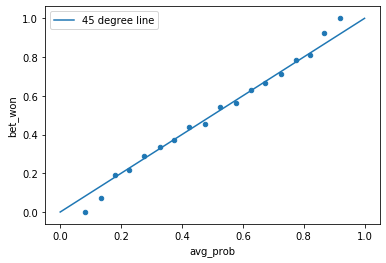

In [158]:
# repeat analysis but look at older years separately (2008 - 2012)

bets_recent = bets[bets.year < 2013]
bins = np.arange(0,1, .05)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets_recent.avg_prob, divided)
grouped = bets_recent.groupby(consensus_group)['bet_won', 'avg_prob'].agg(avg_prob = ('avg_prob', 'mean'),
                                                                   bet_won=('bet_won', 'mean'),
                                                                      n = ('bet_won', 'size'))
grouped = grouped[grouped.bet_won.notna()]
grouped['diff'] = grouped['bet_won'] - grouped['avg_prob']
display(grouped[['avg_prob','bet_won','diff', 'n']])

fig, ax = plt.subplots()
grouped.plot.scatter(x='avg_prob', y = 'bet_won', ax = ax)
x = np.linspace(0, 1, 100)
ax.plot(x, x, label = '45 degree line')
ax.legend(loc='best')
model = smf.wls(formula='bet_won ~ avg_prob', data=grouped, weights = grouped.n).fit()
print(model.summary())

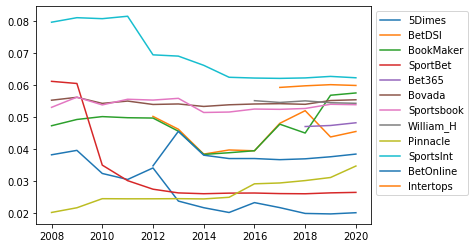

In [159]:
## how have vigs changed over time

fig1, ax1 = plt.subplots()
yeargroup = bets.groupby('year')
for col in betting_sites:
     s = yeargroup.agg(avg_vig= (col+'_vig', 'mean')).reset_index()
     ax1.plot(s.year,s.avg_vig, label = col)
ax1.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

In [160]:
# how do results change if I use probability from betting site with lowest vig for each fight
# rather than the average probability?

bets["lowest_vig"] = bets[[col+"_vig" for col in betting_sites]].apply(pd.Series.idxmin, axis = 1)
print(bets["lowest_vig"].value_counts())
bets["lowest_vig_prob"] = bets.lookup(bets.index, bets["lowest_vig"].apply(lambda x: x[0:-3]+"prob"))

5Dimes_vig        6400
Pinnacle_vig      2044
SportBet_vig       708
BookMaker_vig       64
Sportsbook_vig      16
Bovada_vig           6
BetDSI_vig           2
Name: lowest_vig, dtype: int64


,avg_lowest_vig_prob,bet_won,diff,n
avg_prob,,,,
"(0.05, 0.1]",0.086626,0.047619,-0.039007,42
"(0.1, 0.15000000000000002]",0.133531,0.107143,-0.026388,140
"(0.15000000000000002, 0.2]",0.182196,0.166667,-0.015530,336
"(0.2, 0.25]",0.231919,0.213018,-0.018901,507
"(0.25, 0.30000000000000004]",0.280772,0.261654,-0.019118,665
"(0.30000000000000004, 0.35000000000000003]",0.329894,0.332882,0.002989,739
"(0.35000000000000003, 0.4]",0.378453,0.419608,0.041155,765
"(0.4, 0.45]",0.423617,0.457560,0.033943,754
"(0.45, 0.5]",0.474713,0.463596,-0.011117,673


                            WLS Regression Results                            
Dep. Variable:                bet_won   R-squared:                       0.984
Model:                            WLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     961.2
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           1.02e-15
Time:                        10:44:01   Log-Likelihood:                 38.370
No. Observations:                  18   AIC:                            -72.74
Df Residuals:                      16   BIC:                            -70.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0093    

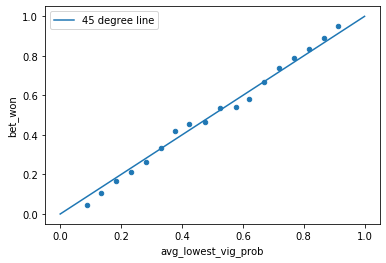

In [161]:
# how well does the lowest vig probability track actual outcomes

bins = np.arange(0,1, .05)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets.avg_prob, divided)
grouped = bets.groupby(consensus_group)['bet_won', "lowest_vig_prob"].agg(avg_lowest_vig_prob = ('lowest_vig_prob', 'mean'),
                                                                   bet_won=('bet_won', 'mean'),
                                                                      n = ('bet_won', 'size'))
grouped = grouped[grouped.bet_won.notna()]
grouped['diff'] = grouped['bet_won'] - grouped['avg_lowest_vig_prob']
display(grouped[['avg_lowest_vig_prob','bet_won','diff', 'n']])

fig, ax = plt.subplots()
grouped.plot.scatter(x='avg_lowest_vig_prob', y = 'bet_won', ax = ax)
x = np.linspace(0, 1, 100)
ax.plot(x, x, label = '45 degree line')
ax.legend(loc='best')
model = smf.wls(formula='bet_won ~ avg_lowest_vig_prob', data=grouped, weights = grouped.n).fit()
print(model.summary())

In [162]:
# compare log loss of simple average versus lowest vig probability

print(np.mean(-np.log(bets[bets.bet_won == 1]['avg_prob'])))
print(np.mean(-np.log(bets[bets.bet_won == 1]["lowest_vig_prob"])))

# on average assigning a 54% win chance to the winning side
print(np.exp(-np.mean(-np.log(bets[bets.bet_won == 1]['avg_prob']))))
print(np.exp(-np.mean(-np.log(bets[bets.bet_won == 1]['lowest_vig_prob']))))


# compare brier score of simple average versus lowest vig probability

print(np.mean((1 - bets[bets.bet_won == 1]['avg_prob'])**2))
print(np.mean((1 - bets[bets.bet_won == 1]['lowest_vig_prob'])**2))

0.6129427637823484
0.613142360910794
0.5417542661806614
0.5416461443755684
0.21264426496661923
0.21270026772241665


count    9240.000000
mean        0.053968
std         0.043402
min         0.000000
25%         0.027570
50%         0.042309
75%         0.066171
max         0.648740
Name: biggest_pct_diff, dtype: float64

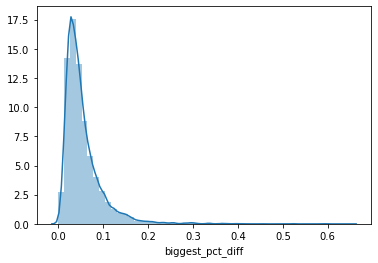

In [163]:
# how much variation is there in vig adjusted probabilities accross the betting sites

bets["max_prob"] = bets[[col+"_prob" for col in betting_sites]].apply("max", axis = 1)
bets["min_prob"] = bets[[col+"_prob" for col in betting_sites]].apply("min", axis = 1)
bets["max_pct_diff"] = np.abs(bets["max_prob"]/bets["avg_prob"] - 1)
bets["min_pct_diff"] = np.abs(bets["min_prob"]/bets["avg_prob"] - 1)
bets["biggest_pct_diff"] = bets[["min_pct_diff", "max_pct_diff"]].apply("max", axis = 1)
sns.distplot(bets["biggest_pct_diff"])
bets["biggest_pct_diff"].describe()

# Investigate Betting Strategy Based on Mispricing Opportunities

In [164]:
# bet only if pd -1 >= r to earn expected value of at least r dollars
# first try using the average probability accross sites
# assuming I always bet at best odds avaiable

bets['best_odds'] = bets[betting_sites].apply("max", axis = 1)
bets['return'] = np.where(bets['bet_won'] == 1, bets['best_odds'] -1, -1)

def get_return(df, r, prob_col):
    df['pd_minus1'] = df['best_odds']*df[prob_col] - 1
    num_fights = df.groupby('year').agg(total_fights = ('pd_minus1', lambda x: x.size/2)).reset_index()
    df = df[df['pd_minus1'] >= r]
    out = df.groupby('year').agg(num_bets = ('pd_minus1', "size"),
                           avg_odds = ('best_odds', "mean"),
                           avg_vig_adjusted_prob = (prob_col, "mean"),
                           pct_won = ('bet_won', "mean"),
                           avg_return = ('return', "mean"),
                           std_return = ('return', 'std')
                          ).reset_index()
    out = pd.merge(num_fights, out, on = 'year')
    out['% fights bet'] = out['num_bets']/out['total_fights']
    return out[['year', 'total_fights', 'num_bets', '% fights bet', 'avg_odds', 
                'avg_vig_adjusted_prob', 'pct_won', 'avg_return', 'std_return']]

In [165]:
## try betting based on mispricing using the average probability

for r in [.01, .02, .03, .04]:
    print("r = "+str(r))
    display(get_return(bets, r, 'avg_prob'))

r = 0.01


,year,total_fights,num_bets,% fights bet,avg_odds,avg_vig_adjusted_prob,pct_won,avg_return,std_return
0,2008,200.0,87,0.435000,1.635352,0.672130,0.701149,0.068936,0.769768
1,2009,212.0,77,0.363208,1.712354,0.639823,0.584416,-0.043379,0.899509
2,2010,250.0,70,0.280000,1.495015,0.705684,0.671429,-0.043781,0.706843
3,2011,295.0,68,0.230508,1.419033,0.728800,0.720588,-0.001285,0.642068
4,2012,333.0,89,0.267267,1.605958,0.669150,0.584270,-0.128948,0.773305
5,2013,376.0,78,0.207447,1.559864,0.681146,0.653846,-0.047933,0.728700
6,2014,493.0,95,0.192698,1.591439,0.671198,0.673684,0.015685,0.774763
7,2015,464.0,97,0.209052,1.735301,0.657539,0.680412,0.068270,0.841330
8,2016,482.0,94,0.195021,1.597412,0.673146,0.648936,-0.005255,0.810454
9,2017,445.0,119,0.267416,1.681360,0.648194,0.647059,0.009243,0.810019


r = 0.02


,year,total_fights,num_bets,% fights bet,avg_odds,avg_vig_adjusted_prob,pct_won,avg_return,std_return
0,2008,200.0,32,0.160000,1.851907,0.627810,0.593750,-0.040443,0.885886
1,2009,212.0,27,0.127358,1.752342,0.635182,0.592593,-0.048928,0.861321
2,2010,250.0,24,0.096000,1.471409,0.715607,0.625000,-0.121193,0.711300
3,2011,295.0,23,0.077966,1.431476,0.725592,0.782609,0.089735,0.600215
4,2012,333.0,24,0.072072,1.879726,0.588272,0.458333,-0.187532,0.952790
5,2013,376.0,22,0.058511,1.654798,0.647871,0.727273,0.131442,0.753604
6,2014,493.0,17,0.034483,1.888927,0.575812,0.529412,0.066534,1.113031
7,2015,464.0,36,0.077586,2.024119,0.580311,0.722222,0.307411,0.977193
8,2016,482.0,32,0.066390,1.734434,0.641580,0.593750,0.013473,0.968179
9,2017,445.0,44,0.098876,1.814827,0.622055,0.613636,0.022976,0.906077


r = 0.03


,year,total_fights,num_bets,% fights bet,avg_odds,avg_vig_adjusted_prob,pct_won,avg_return,std_return
0,2008,200.0,12,0.060000,2.184554,0.574033,0.416667,-0.240569,0.988461
1,2009,212.0,6,0.028302,2.019200,0.526055,0.500000,-0.016197,1.106482
2,2010,250.0,9,0.036000,1.534659,0.698345,0.555556,-0.246229,0.719080
3,2012,333.0,11,0.033033,2.201166,0.509022,0.545455,0.098576,1.110178
4,2013,376.0,6,0.015957,1.883333,0.576202,0.833333,0.450000,0.766201
5,2014,493.0,7,0.014199,2.134742,0.516685,0.714286,0.553375,1.194658
6,2015,464.0,20,0.043103,2.083710,0.553696,0.800000,0.606210,1.023978
7,2016,482.0,15,0.031120,1.968296,0.563693,0.666667,0.308301,1.080924
8,2017,445.0,14,0.031461,2.081449,0.550024,0.500000,-0.095503,1.008098
9,2018,471.0,39,0.082803,2.112522,0.576791,0.692308,0.304954,1.054944


r = 0.04


,year,total_fights,num_bets,% fights bet,avg_odds,avg_vig_adjusted_prob,pct_won,avg_return,std_return
0,2008,200.0,5,0.025000,2.030267,0.591580,0.400000,-0.145072,1.206479
1,2009,212.0,3,0.014151,1.967607,0.549982,1.000000,0.967607,0.396419
2,2012,333.0,6,0.018018,2.557527,0.433808,0.333333,-0.158333,1.304767
3,2013,376.0,2,0.005319,2.085714,0.535187,0.500000,-0.214286,1.111168
4,2014,493.0,3,0.006085,2.255278,0.499479,0.666667,0.632090,1.578101
5,2015,464.0,9,0.019397,2.451376,0.477701,0.666667,0.645820,1.389833
6,2016,482.0,7,0.014523,1.931950,0.582796,0.571429,0.069312,1.101262
7,2017,445.0,8,0.017978,2.104625,0.558540,0.375000,-0.320040,1.024295
8,2018,471.0,28,0.059448,2.317827,0.537386,0.607143,0.258476,1.196027
9,2019,507.0,4,0.007890,2.850000,0.449292,0.500000,0.662500,2.034443


In [166]:
## try betting based on mispricing using the probability from the betting site with the lowest vig

for r in [.01, .02, .03, .04]:
    print("r = "+str(r))
    display(get_return(bets, r, "lowest_vig_prob"))

r = 0.01


,year,total_fights,num_bets,% fights bet,avg_odds,avg_vig_adjusted_prob,pct_won,avg_return,std_return
0,2008,200.0,63,0.315000,1.879548,0.611330,0.523810,-0.105961,0.962783
1,2009,212.0,76,0.358491,2.133147,0.544323,0.500000,-0.090942,1.022642
2,2010,250.0,61,0.244000,2.290294,0.517168,0.459016,-0.147645,1.040316
3,2011,295.0,43,0.145763,2.107626,0.551818,0.581395,0.104014,1.084718
4,2012,333.0,99,0.297297,2.006534,0.572988,0.494949,-0.158692,0.922256
5,2013,376.0,76,0.202128,1.942570,0.581376,0.552632,-0.056247,0.947188
6,2014,493.0,88,0.178499,2.103574,0.567134,0.488636,-0.192887,0.910860
7,2015,464.0,98,0.211207,1.942393,0.597941,0.683673,0.198717,0.961425
8,2016,482.0,129,0.267635,1.812223,0.617522,0.612403,-0.000456,0.879372
9,2017,445.0,124,0.278652,1.884420,0.613412,0.637097,0.100614,0.972097


r = 0.02


,year,total_fights,num_bets,% fights bet,avg_odds,avg_vig_adjusted_prob,pct_won,avg_return,std_return
0,2008,200.0,39,0.195000,2.071451,0.559415,0.512821,-0.003094,1.093413
1,2009,212.0,47,0.221698,2.130826,0.535652,0.553191,0.012974,0.984207
2,2010,250.0,30,0.120000,2.486084,0.483978,0.400000,-0.219113,1.080102
3,2011,295.0,22,0.074576,2.346660,0.516089,0.500000,0.033689,1.201447
4,2012,333.0,47,0.141141,2.120141,0.540003,0.382979,-0.326257,0.919809
5,2013,376.0,35,0.093085,2.017113,0.567273,0.542857,-0.069416,0.960160
6,2014,493.0,38,0.077079,2.367065,0.493875,0.368421,-0.303313,0.988437
7,2015,464.0,48,0.103448,2.152998,0.548846,0.583333,0.104405,1.076987
8,2016,482.0,59,0.122407,2.018100,0.574893,0.508475,-0.120313,0.952319
9,2017,445.0,71,0.159551,2.025103,0.581022,0.633803,0.174118,1.033579


r = 0.03


,year,total_fights,num_bets,% fights bet,avg_odds,avg_vig_adjusted_prob,pct_won,avg_return,std_return
0,2008,200.0,19,0.095000,2.222703,0.536028,0.526316,0.192518,1.269910
1,2009,212.0,21,0.099057,2.210700,0.521229,0.571429,0.057185,0.975838
2,2010,250.0,13,0.052000,2.539876,0.478165,0.384615,-0.297680,1.010779
3,2011,295.0,9,0.030508,3.108476,0.402470,0.555556,0.275142,1.414880
4,2012,333.0,21,0.063063,2.279473,0.502744,0.333333,-0.315423,1.049748
5,2013,376.0,18,0.047872,2.155168,0.523002,0.611111,0.206566,1.092204
6,2014,493.0,17,0.034483,2.394532,0.482699,0.529412,0.143939,1.172914
7,2015,464.0,25,0.053879,2.504894,0.479328,0.600000,0.322494,1.237324
8,2016,482.0,32,0.066390,2.168611,0.531312,0.500000,-0.014706,1.076958
9,2017,445.0,43,0.096629,2.292481,0.523015,0.627907,0.268652,1.137694


r = 0.04


,year,total_fights,num_bets,% fights bet,avg_odds,avg_vig_adjusted_prob,pct_won,avg_return,std_return
0,2008,200.0,13,0.065000,2.470977,0.483657,0.615385,0.492589,1.343932
1,2009,212.0,14,0.066038,2.377984,0.480053,0.571429,0.159617,1.064492
2,2010,250.0,5,0.020000,2.542294,0.434978,0.400000,-0.227706,1.057618
3,2011,295.0,5,0.016949,3.728108,0.337337,0.400000,0.108108,1.748839
4,2012,333.0,12,0.036036,2.465994,0.466357,0.333333,-0.280147,1.089901
5,2013,376.0,5,0.013298,2.279286,0.503958,0.600000,0.079286,1.015594
6,2014,493.0,10,0.020284,2.405583,0.465469,0.600000,0.378627,1.246815
7,2015,464.0,17,0.036638,2.577540,0.479443,0.588235,0.289304,1.242515
8,2016,482.0,21,0.043568,2.180669,0.527434,0.619048,0.291024,1.129131
9,2017,445.0,26,0.058427,2.429277,0.490114,0.461538,-0.052405,1.104636


# Investigate Betting Strategy Based On Betting On Fighters with Avg Probability of Winning = 37% - 43% 

In [150]:
def get_return_based_on_prob_range(df, prob_col, prob_min, prob_max):
    num_fights = df.groupby('year').agg(total_fights = ('pd_minus1', lambda x: x.size/2)).reset_index()
    df = df[(df[prob_col] >= prob_min) & (df[prob_col] <= prob_max)]
    out = df.groupby('year').agg(num_bets = ('pd_minus1', "size"),
                           avg_odds = ('best_odds', "mean"),
                           avg_vig_adjusted_prob = (prob_col, "mean"),
                           pct_won = ('bet_won', "mean"),
                           avg_return = ('return', "mean"),
                           std_return = ('return', 'std')
                          ).reset_index()
    out = pd.merge(num_fights, out, on = 'year')
    out['% fights bet'] = out['num_bets']/out['total_fights']
    return out[['year', 'total_fights', 'num_bets', '% fights bet', 'avg_odds', 
                'avg_vig_adjusted_prob', 'pct_won', 'avg_return', 'std_return']]
print('bets with avg vig adjusted probability in the .37 to .43 range')
display(get_return_based_on_prob_range(bets, 'avg_prob', .37, .43))

bets with avg vig adjusted probability in the .37 to .43 range


,year,total_fights,num_bets,% fights bet,avg_odds,avg_vig_adjusted_prob,pct_won,avg_return,std_return
0,2008,200.0,39,0.195000,2.457949,0.401881,0.410256,0.005641,1.223211
1,2009,212.0,35,0.165094,2.446000,0.403910,0.400000,-0.035143,1.201304
2,2010,250.0,53,0.212000,2.452453,0.399687,0.377358,-0.073585,1.203065
3,2011,295.0,47,0.159322,2.445745,0.399617,0.361702,-0.130851,1.168468
4,2012,333.0,57,0.171171,2.457368,0.401301,0.350877,-0.143860,1.176095
5,2013,376.0,69,0.183511,2.468551,0.397950,0.434783,0.065507,1.226124
6,2014,493.0,98,0.198783,2.449388,0.400653,0.408163,0.001633,1.213877
7,2015,464.0,91,0.196121,2.472967,0.397532,0.494505,0.226374,1.249089
8,2016,482.0,118,0.244813,2.455254,0.399534,0.516949,0.271610,1.237259
9,2017,445.0,95,0.213483,2.453368,0.400829,0.410526,0.012842,1.222386


# Use Simulation to Determine How Accurate Avg_Prob is as forecaster

In [175]:
def log_loss(p, y):
    return -np.mean(y*np.log(p)+(1-y)*np.log(1 - p))

def brier(p, y):
    return np.mean(y*(1 - p)**2 + (1-y)*(p**2))

winning_probs = bets.loc[bets['bet_won'] == 1, "avg_prob"]
print(len(winning_probs))
sim = 1000
df = pd.DataFrame()
df['brier'] = np.repeat(np.nan, sim)
df['log_loss'] = np.nan
numpy.random.seed(22)
for k in range(sim):
    y = np.random.binomial(1, winning_probs)
    df['brier'].iloc[k] = brier(winning_probs, y)
    df['log_loss'].iloc[k] =log_loss(winning_probs, y)
print(df.describe())   

print(-np.mean(np.log(bets[bets.bet_won == 1]['avg_prob'])))
print(np.mean((1 - bets[bets.bet_won == 1]['avg_prob'])**2))


4620
             brier     log_loss
count  1000.000000  1000.000000
mean      0.212728     0.613977
std       0.002419     0.005405
min       0.206530     0.599728
25%       0.211010     0.610183
50%       0.212639     0.613797
75%       0.214322     0.617538
max       0.220540     0.630765
0.6129427637823484
0.21264426496661923


It doesn't seem worth it/posible to come up with a better forecaster than the average probability.